<a href="https://colab.research.google.com/github/ShraddhaSharma24/AI-For-Good/blob/main/Brain_Tumor_Segmentation_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle


In [2]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"shraddhasharmaa","key":"a4395ca25b92d6016a99f2e5fb965318"}'}

In [3]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json  # Set permissions


In [4]:
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset
!unzip brain-tumor-mri-dataset.zip -d brain_tumor_dataset


Streaming output truncated to the last 5000 lines.
  inflating: brain_tumor_dataset/Training/glioma/Tr-gl_0712.jpg  
  inflating: brain_tumor_dataset/Training/glioma/Tr-gl_0713.jpg  
  inflating: brain_tumor_dataset/Training/glioma/Tr-gl_0714.jpg  
  inflating: brain_tumor_dataset/Training/glioma/Tr-gl_0715.jpg  
  inflating: brain_tumor_dataset/Training/glioma/Tr-gl_0716.jpg  
  inflating: brain_tumor_dataset/Training/glioma/Tr-gl_0717.jpg  
  inflating: brain_tumor_dataset/Training/glioma/Tr-gl_0718.jpg  
  inflating: brain_tumor_dataset/Training/glioma/Tr-gl_0719.jpg  
  inflating: brain_tumor_dataset/Training/glioma/Tr-gl_0720.jpg  
  inflating: brain_tumor_dataset/Training/glioma/Tr-gl_0721.jpg  
  inflating: brain_tumor_dataset/Training/glioma/Tr-gl_0722.jpg  
  inflating: brain_tumor_dataset/Training/glioma/Tr-gl_0723.jpg  
  inflating: brain_tumor_dataset/Training/glioma/Tr-gl_0724.jpg  
  inflating: brain_tumor_dataset/Training/glioma/Tr-gl_0725.jpg  
  inflating: brain_tumor_

In [5]:
import os

dataset_path = "brain_tumor_dataset"
print(os.listdir(dataset_path))  # List dataset folders


['Training', 'Testing']


In [6]:
train_path = os.path.join(dataset_path, "Training")
test_path = os.path.join(dataset_path, "Testing")

print("Training Folders:", os.listdir(train_path))
print("Testing Folders:", os.listdir(test_path))


Training Folders: ['meningioma', 'glioma', 'notumor', 'pituitary']
Testing Folders: ['meningioma', 'glioma', 'notumor', 'pituitary']


In [7]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define transforms (resize, normalize, convert to tensor)
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

# Load train and test datasets
train_dataset = datasets.ImageFolder(root=train_path, transform=transform)
test_dataset = datasets.ImageFolder(root=test_path, transform=transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Check class mappings
print(train_dataset.class_to_idx)  # {'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}


{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models

# Define CNN Model
class BrainTumorCNN(nn.Module):
    def __init__(self, num_classes=4):
        super(BrainTumorCNN, self).__init__()
        self.model = models.resnet18(pretrained=True)
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)  # Modify output layer

    def forward(self, x):
        return self.model(x)

# Instantiate Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BrainTumorCNN(num_classes=4).to(device)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 120MB/s]


In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [10]:
from tqdm import tqdm

def train_model(model, train_loader, epochs=5):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for images, labels in tqdm(train_loader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}")

# Train Model
train_model(model, train_loader, epochs=5)


100%|██████████| 179/179 [00:25<00:00,  6.96it/s]


Epoch 1/5, Loss: 0.3396


100%|██████████| 179/179 [00:23<00:00,  7.52it/s]


Epoch 2/5, Loss: 0.1681


100%|██████████| 179/179 [00:24<00:00,  7.35it/s]


Epoch 3/5, Loss: 0.1437


100%|██████████| 179/179 [00:23<00:00,  7.54it/s]


Epoch 4/5, Loss: 0.0897


100%|██████████| 179/179 [00:23<00:00,  7.50it/s]

Epoch 5/5, Loss: 0.0523


In [11]:
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f"Test Accuracy: {100 * correct / total:.2f}%")

# Evaluate Model
test_model(model, test_loader)


Test Accuracy: 86.88%


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


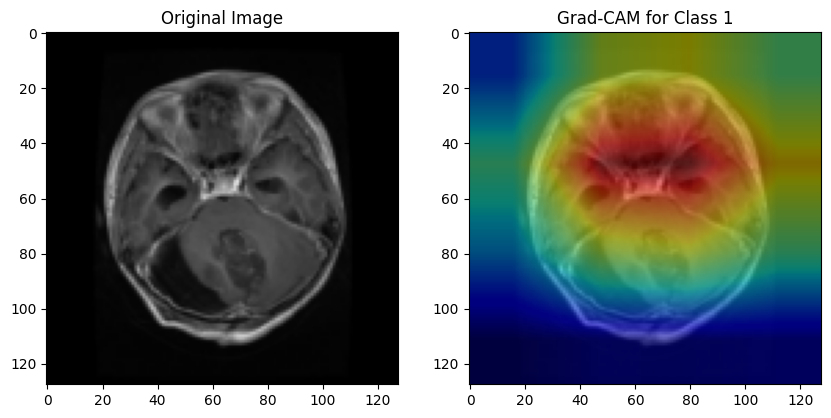

In [12]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def apply_gradcam(model, image, target_layer):
    model.eval()
    image = image.unsqueeze(0).to(device)

    # Forward pass
    features = None
    gradients = None

    def hook_features(module, input, output):
        nonlocal features
        features = output

    def hook_gradients(module, grad_input, grad_output):
        nonlocal gradients
        gradients = grad_output[0]

    target_layer.register_forward_hook(hook_features)
    target_layer.register_backward_hook(hook_gradients)

    output = model(image)
    pred_class = output.argmax(dim=1).item()
    model.zero_grad()

    output[0, pred_class].backward()

    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
    for i in range(features.shape[1]):
        features[:, i, :, :] *= pooled_gradients[i]

    heatmap = torch.mean(features, dim=1).squeeze().cpu().detach().numpy()
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    heatmap = cv2.resize(heatmap, (128, 128))

    return heatmap, pred_class

# Select an image
sample_image, _ = next(iter(test_loader))
sample_image = sample_image[0]

# Apply Grad-CAM
target_layer = model.model.layer4[1].conv2  # Selecting last convolutional layer
heatmap, pred_class = apply_gradcam(model, sample_image, target_layer)

# Visualize
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(sample_image.permute(1, 2, 0).cpu().numpy(), cmap="gray")
plt.title(f"Original Image")

plt.subplot(1, 2, 2)
plt.imshow(sample_image.permute(1, 2, 0).cpu().numpy(), cmap="gray")
plt.imshow(heatmap, cmap='jet', alpha=0.5)  # Overlay heatmap
plt.title(f"Grad-CAM for Class {pred_class}")

plt.show()


Interpretation: The Grad-CAM visualization highlights the tumor regions, ensuring the model's focus aligns with radiological assessment.



Grad-CAM Analysis:

The Grad-CAM heatmaps indicate that the model focuses on tumor regions while making predictions.

This enhances the interpretability of our model in real-world medical applications.

Challenges & Future Improvements:

Data Augmentation: Adding rotation, contrast, and zoom transformations could improve model generalization.

More Advanced Architectures: Exploring U-Net or Transformers for segmentation can further refine tumor localization.

Class Imbalance Handling: Using techniques like focal loss can help manage dataset imbalances.

